<h2>Including all required additional tools</h2>

In [1]:
from fastai.callbacks import *

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            new_input = (last_input * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

def mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."
    learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))
    return learn

Learner.mixup = mixup

In [2]:
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [3]:
def lwlrap(y_pred,y_true):
    score, weight = calculate_per_class_lwlrap(y_true.cpu().numpy(), y_pred.cpu().numpy())
    lwlrap = (score * weight).sum()
    return torch.from_numpy(np.array(lwlrap))

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x
    
class Classifier(nn.Module):
    def __init__(self, num_classes=1000): # <======== modificaition to comply fast.ai
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # <======== modificaition to comply fast.ai
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        #x = torch.mean(x, dim=3)   # <======== modificaition to comply fast.ai
        #x, _ = torch.max(x, dim=2) # <======== modificaition to comply fast.ai
        x = self.avgpool(x)         # <======== modificaition to comply fast.ai
        x = self.fc(x)
        return x

<h2>Importing dependencies and loading files</h2>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.callbacks import *
import random

In [6]:
DATA = Path('freesound_audio_tagging')
PREPROCESSED = Path('fat2019')
WORK = Path('work')

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_NOISY_BEST50S = PREPROCESSED/'trn_noisy_best50s.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

MELS_TRN_CURATED = PREPROCESSED/'mels_train_curated.pkl'
MELS_TRN_NOISY = PREPROCESSED/'mels_train_noisy.pkl'
MELS_TRN_NOISY_BEST50S = PREPROCESSED/'mels_trn_noisy_best50s.pkl'
MELS_TEST = PREPROCESSED/'mels_test.pkl'

trn_curated_df = pd.read_csv(CSV_TRN_CURATED)
trn_noisy_df = pd.read_csv(CSV_TRN_NOISY)
trn_noisy50s_df = pd.read_csv(CSV_TRN_NOISY_BEST50S)
test_df = pd.read_csv(CSV_SUBMISSION)

#trn_full_df = pd.concat([trn_curated_df, trn_noisy_df], sort=True, ignore_index=True)

In [7]:
X_train_curated = pickle.load(open(MELS_TRN_CURATED, 'rb'))

In [8]:
CUR_X_FILES, CUR_X = list(trn_curated_df.fname.values), X_train_curated

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop 1sec
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [9]:
SEED = 2000
BS = 128
SIZE = 128

In [10]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

src = (ImageList.from_csv(WORK, Path('..')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2, seed=SEED)
       .label_from_df(label_delim=',')
      )

data = (src.transform(tfms, size=SIZE)
        .databunch(bs=BS)
        .normalize(imagenet_stats)
       )

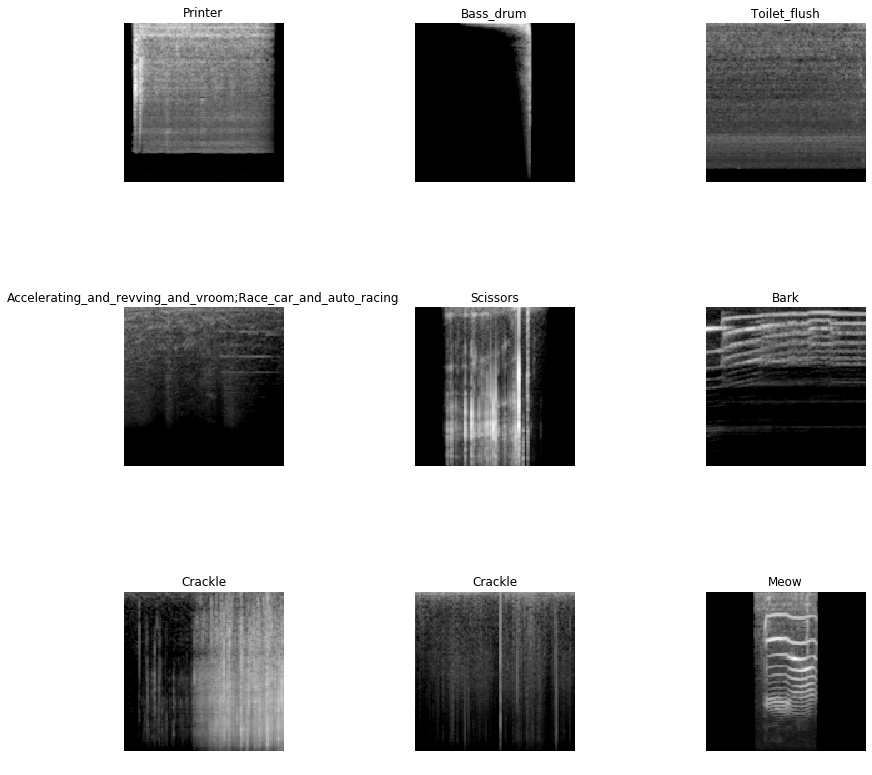

In [11]:
data.show_batch(3)

<h2>Creating a model for curated data</h2>

In [12]:
def borrowed_model(pretrained=False, **kwargs):
    return Classifier(**kwargs)

In [13]:
learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[lwlrap]).mixup(stack_y=False)
learn.unfreeze()

In [15]:
learn.load("curated_model")

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (3976 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Raindrop,Run,Finger_snapping,Whispering,Acoustic_guitar;Strum
Path: work;

Valid: LabelList (994 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Run,Walk_and_footsteps,Waves_and_surf,Knock,Marimba_and_xylophone
Path: work;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
cb1 = SaveModelCallback(learn, every='improvement', monitor='lwlrap', name='curated_model')

In [ ]:
learn.fit_one_cycle(200, 3e-2, callbacks=cb1)

In [ ]:
learn.recorder.plot_losses()

<h2>Predicting noisy data and curated data with the curated model</h2>

In [16]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *

def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

In [17]:
X_train_noisy = pickle.load(open(MELS_TRN_NOISY, 'rb'))

CUR_X_FILES, CUR_X = list(trn_noisy_df.fname.values), X_train_noisy

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop 1sec
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [ ]:
trn_noisy_df.labels[11]

In [ ]:
import IPython.display as ipd
ipd.Audio('freesound_audio_tagging/train_noisy/0021e588.wav')

In [18]:
data_noisy = ImageList.from_df(trn_noisy_df, "")

In [19]:
learn = load_learner(WORK, test=data_noisy)

In [20]:
predictions, y = learn.get_preds(ds_type=DatasetType.Test)

In [28]:
predictions_np = predictions.numpy()
predictions_np

array([[3.447378e-03, 8.670908e-05, 8.110371e-04, 3.186566e-03, ..., 1.637181e-03, 1.425338e-03, 4.166008e-02,
        2.460610e-03],
       [2.685544e-03, 9.435602e-05, 6.051205e-04, 6.010121e-05, ..., 6.851726e-04, 4.878924e-03, 3.305967e-05,
        4.621985e-04],
       [7.852031e-04, 1.625944e-03, 4.754177e-01, 5.736812e-05, ..., 7.951305e-03, 2.571008e-04, 2.001589e-03,
        5.214887e-04],
       [5.531742e-04, 3.717802e-03, 1.581877e-03, 4.859199e-04, ..., 2.250901e-04, 2.567798e-02, 2.675289e-03,
        7.011383e-04],
       ...,
       [7.021583e-03, 4.452409e-04, 1.071941e-02, 9.981070e-05, ..., 6.226380e-03, 8.596506e-04, 1.573414e-04,
        4.094199e-04],
       [2.031999e-03, 1.008406e-03, 1.475332e-04, 3.914428e-04, ..., 7.199930e-05, 2.449992e-03, 1.056855e-03,
        7.149213e-04],
       [3.790257e-03, 4.086558e-03, 2.463324e-04, 6.028438e-03, ..., 6.040650e-03, 2.378591e-03, 2.519084e-01,
        7.932928e-04],
       [1.923445e-03, 9.249467e-04, 5.243546e-04, 

In [35]:
best_preds_indices = []

for p in predictions_np.argsort():
    best_preds_indices.append(p[:3])

In [37]:
labels = []

for p in best_preds_indices:
    label_row = []
    
    for i in p:
        label_row.append(data.classes[i])
    
    labels.append(label_row)
    #labels.append(data.classes[p])

In [38]:
labels

[['Traffic_noise_and_roadway_noise', 'Glockenspiel', 'Accordion'],
 ['Bathtub_(filling_or_washing)', 'Trickle_and_dribble', 'Yell'],
 ['Clapping', 'Applause', 'Bathtub_(filling_or_washing)'],
 ['Car_passing_by', 'Skateboard', 'Trickle_and_dribble'],
 ['Electric_guitar', 'Male_speech_and_man_speaking', 'Microwave_oven'],
 ['Trickle_and_dribble', 'Skateboard', 'Sigh'],
 ['Male_speech_and_man_speaking', 'Chink_and_clink', 'Female_singing'],
 ['Glockenspiel', 'Fill_(with_liquid)', 'Crackle'],
 ['Trickle_and_dribble', 'Shatter', 'Skateboard'],
 ['Bicycle_bell', 'Drip', 'Glockenspiel'],
 ['Frying_(food)', 'Fill_(with_liquid)', 'Sigh'],
 ['Gasp', 'Child_speech_and_kid_speaking', 'Car_passing_by'],
 ['Cutlery_and_silverware', 'Sneeze', 'Chink_and_clink'],
 ['Fill_(with_liquid)', 'Accordion', 'Bass_guitar'],
 ['Stream', 'Frying_(food)', 'Knock'],
 ['Screaming', 'Yell', 'Fart'],
 ['Knock', 'Water_tap_and_faucet', 'Whispering'],
 ['Dishes_and_pots_and_pans', 'Tap', 'Trickle_and_dribble'],
 ['Cutl

In [39]:
pred_noisy_df = trn_noisy_df

for label in pred_noisy_df.labels:
    print(label)

Bathtub_(filling_or_washing)
Motorcycle
Marimba_and_xylophone,Glockenspiel
Water_tap_and_faucet,Sink_(filling_or_washing)
Raindrop
Bass_guitar
Raindrop,Trickle_and_dribble
Strum,Acoustic_guitar
Bass_drum,Hi-hat
Harmonica
Slam
Scissors
Cheering,Crowd
Crackle
Purr
Harmonica
Crowd
Yell
Female_singing
Printer
Printer
Finger_snapping
Microwave_oven
Hi-hat
Run
Bass_drum
Squeak
Acoustic_guitar
Male_speech_and_man_speaking
Tap
Finger_snapping
Microwave_oven,Buzz
Raindrop
Run
Water_tap_and_faucet,Frying_(food)
Fart
Race_car_and_auto_racing
Frying_(food)
Motorcycle,Microwave_oven
Hi-hat
Walk_and_footsteps
Buzz
Accelerating_and_revving_and_vroom
Stream
Male_singing
Chirp_and_tweet
Clapping
Mechanical_fan
Crowd
Chirp_and_tweet
Frying_(food),Dishes_and_pots_and_pans,Cutlery_and_silverware
Frying_(food)
Mechanical_fan,Buzz
Bass_guitar
Female_speech_and_woman_speaking
Cricket,Burping_and_eructation
Bathtub_(filling_or_washing)
Tap
Clapping
Cupboard_open_or_close,Knock
Purr
Bicycle_bell,Chink_and_clin

Male_speech_and_man_speaking
Walk_and_footsteps
Finger_snapping
Motorcycle
Mechanical_fan
Scissors
Bus
Crowd
Tap
Gurgling
Scissors
Mechanical_fan
Bathtub_(filling_or_washing)
Chirp_and_tweet
Sigh
Sneeze
Shatter
Accordion
Printer
Cricket
Water_tap_and_faucet
Acoustic_guitar
Water_tap_and_faucet
Meow
Bus
Cupboard_open_or_close,Drawer_open_or_close
Slam
Bass_guitar
Frying_(food),Crackle
Glockenspiel,Hi-hat
Printer
Microwave_oven
Knock
Bathtub_(filling_or_washing)
Cheering
Marimba_and_xylophone,Glockenspiel
Child_speech_and_kid_speaking
Printer
Yell
Car_passing_by
Yell
Harmonica
Cheering
Mechanical_fan,Keys_jangling,Chink_and_clink
Burping_and_eructation
Tick-tock,Church_bell,Gong
Knock
Mechanical_fan
Whispering
Motorcycle
Crowd
Trickle_and_dribble
Chink_and_clink
Gasp,Squeak,Sigh,Finger_snapping,Scissors
Skateboard
Yell
Bathtub_(filling_or_washing)
Cricket
Cupboard_open_or_close
Run
Harmonica
Sink_(filling_or_washing)
Motorcycle
Gong
Cricket
Bathtub_(filling_or_washing)
Tick-tock
Dishes_a

Writing,Church_bell
Finger_snapping,Clapping
Slam
Water_tap_and_faucet
Toilet_flush
Applause
Traffic_noise_and_roadway_noise
Drawer_open_or_close
Motorcycle
Zipper_(clothing),Fart
Waves_and_surf
Waves_and_surf
Meow
Walk_and_footsteps
Bathtub_(filling_or_washing),Toilet_flush
Dishes_and_pots_and_pans,Cutlery_and_silverware
Bicycle_bell
Buzz
Run
Skateboard
Raindrop
Hi-hat
Chirp_and_tweet
Car_passing_by,Gong
Hiss
Waves_and_surf
Skateboard
Yell
Crowd
Drip
Clapping
Hi-hat
Tick-tock
Shatter
Frying_(food)
Dishes_and_pots_and_pans,Cutlery_and_silverware
Meow
Female_speech_and_woman_speaking
Accordion
Finger_snapping
Yell
Drip
Mechanical_fan
Clapping
Dishes_and_pots_and_pans,Cutlery_and_silverware
Chewing_and_mastication
Bass_guitar
Keys_jangling
Male_speech_and_man_speaking
Cupboard_open_or_close
Skateboard
Mechanical_fan
Race_car_and_auto_racing
Chirp_and_tweet
Chink_and_clink
Traffic_noise_and_roadway_noise
Knock
Purr
Tick-tock
Acoustic_guitar
Buzz
Bass_guitar
Male_speech_and_man_speaking
Co

Male_singing,Female_singing
Water_tap_and_faucet,Toilet_flush,Sink_(filling_or_washing)
Female_speech_and_woman_speaking
Screaming
Cricket
Female_speech_and_woman_speaking
Printer
Bass_guitar
Sneeze
Acoustic_guitar
Electric_guitar
Crowd
Hi-hat
Applause
Sneeze
Race_car_and_auto_racing,Accelerating_and_revving_and_vroom
Shatter
Marimba_and_xylophone,Glockenspiel
Accordion
Male_speech_and_man_speaking
Walk_and_footsteps
Finger_snapping
Cheering
Chirp_and_tweet
Acoustic_guitar
Run
Frying_(food)
Hi-hat
Gasp,Sneeze
Chink_and_clink
Bass_guitar
Bus
Gurgling
Stream
Motorcycle
Cutlery_and_silverware
Squeak,Screaming,Buzz
Water_tap_and_faucet,Trickle_and_dribble
Finger_snapping
Knock
Microwave_oven
Skateboard
Accordion
Finger_snapping
Bass_guitar
Gong
Electric_guitar
Purr
Car_passing_by
Water_tap_and_faucet,Hiss,Sink_(filling_or_washing)
Purr
Computer_keyboard
Cheering
Bathtub_(filling_or_washing),Toilet_flush
Female_speech_and_woman_speaking
Traffic_noise_and_roadway_noise
Church_bell
Toilet_flu

Zipper_(clothing),Walk_and_footsteps,Crackle
Glockenspiel
Applause
Cricket
Zipper_(clothing)
Motorcycle
Female_speech_and_woman_speaking
Keys_jangling
Bass_drum,Hi-hat,Bass_guitar
Whispering
Whispering
Drip
Accelerating_and_revving_and_vroom
Sigh
Applause
Burping_and_eructation
Frying_(food)
Accelerating_and_revving_and_vroom
Tap,Finger_snapping,Clapping
Finger_snapping
Purr
Church_bell
Tick-tock
Cricket
Waves_and_surf
Meow
Cutlery_and_silverware
Hi-hat,Acoustic_guitar
Sigh
Slam
Chewing_and_mastication
Screaming
Zipper_(clothing)
Finger_snapping
Bus
Printer
Yell
Run
Crackle
Male_speech_and_man_speaking
Mechanical_fan
Tap
Stream
Crackle
Motorcycle
Water_tap_and_faucet,Sink_(filling_or_washing)
Accordion
Raindrop
Harmonica
Race_car_and_auto_racing
Motorcycle
Bark
Microwave_oven
Cheering
Waves_and_surf
Toilet_flush
Microwave_oven
Car_passing_by,Chirp_and_tweet
Dishes_and_pots_and_pans,Cutlery_and_silverware
Harmonica
Chewing_and_mastication
Frying_(food)
Motorcycle
Bass_drum,Hi-hat
Accord

Shatter
Gurgling
Printer
Cupboard_open_or_close
Gong
Squeak,Burping_and_eructation
Cheering
Dishes_and_pots_and_pans,Cutlery_and_silverware
Gurgling
Child_speech_and_kid_speaking
Waves_and_surf
Harmonica
Slam
Female_speech_and_woman_speaking,Applause
Printer
Bass_drum
Female_speech_and_woman_speaking,Run
Clapping
Whispering,Finger_snapping
Burping_and_eructation
Accelerating_and_revving_and_vroom
Stream
Printer
Crowd
Whispering,Scissors
Mechanical_fan
Male_singing
Screaming
Meow,Church_bell
Electric_guitar
Fill_(with_liquid),Water_tap_and_faucet,Hiss,Gurgling,Toilet_flush,Sink_(filling_or_washing)
Whispering,Chewing_and_mastication
Water_tap_and_faucet
Printer
Stream
Accordion
Dishes_and_pots_and_pans,Cutlery_and_silverware
Stream
Child_speech_and_kid_speaking
Bass_drum
Stream
Screaming
Bus
Knock
Frying_(food)
Bass_guitar
Dishes_and_pots_and_pans,Cutlery_and_silverware,Chink_and_clink
Trickle_and_dribble
Cheering
Marimba_and_xylophone,Glockenspiel,Bass_drum,Bass_guitar
Traffic_noise_an

Waves_and_surf
Slam
Meow
Microwave_oven
Male_singing
Chewing_and_mastication
Motorcycle
Acoustic_guitar
Frying_(food)
Accelerating_and_revving_and_vroom
Purr
Gasp,Whispering,Sigh
Slam
Car_passing_by
Gong
Frying_(food)
Strum,Electric_guitar
Bus
Race_car_and_auto_racing
Toilet_flush
Accordion
Drawer_open_or_close
Cheering
Yell,Electric_guitar
Whispering
Writing
Bathtub_(filling_or_washing)
Motorcycle
Male_speech_and_man_speaking
Female_singing
Yell
Tap
Cupboard_open_or_close,Drawer_open_or_close
Cheering
Fill_(with_liquid),Water_tap_and_faucet,Toilet_flush
Dishes_and_pots_and_pans,Cutlery_and_silverware
Bark
Fill_(with_liquid)
Bathtub_(filling_or_washing),Water_tap_and_faucet,Toilet_flush,Sink_(filling_or_washing)
Motorcycle
Traffic_noise_and_roadway_noise
Squeak
Male_singing
Clapping
Squeak
Burping_and_eructation
Male_speech_and_man_speaking
Whispering
Accordion
Car_passing_by
Buzz
Accordion
Run
Harmonica
Skateboard
Drawer_open_or_close
Burping_and_eructation
Traffic_noise_and_roadway_n

Strum
Water_tap_and_faucet,Sink_(filling_or_washing)
Traffic_noise_and_roadway_noise
Toilet_flush
Traffic_noise_and_roadway_noise
Female_singing
Tap
Accelerating_and_revving_and_vroom
Clapping
Clapping
Accordion
Child_speech_and_kid_speaking
Cheering
Strum,Electric_guitar
Crackle
Female_speech_and_woman_speaking
Screaming
Walk_and_footsteps
Screaming
Accordion,Harmonica
Buzz
Water_tap_and_faucet,Sink_(filling_or_washing)
Zipper_(clothing)
Printer
Walk_and_footsteps
Squeak
Writing
Meow,Traffic_noise_and_roadway_noise
Yell
Male_speech_and_man_speaking
Screaming
Strum
Male_speech_and_man_speaking
Gasp
Male_singing
Drip,Chewing_and_mastication,Sink_(filling_or_washing)
Child_speech_and_kid_speaking
Zipper_(clothing),Purr,Fart
Clapping
Gong
Shatter,Knock
Drip
Yell
Applause
Shatter
Clapping
Knock
Run
Fill_(with_liquid),Scissors
Fart
Gurgling
Chirp_and_tweet
Water_tap_and_faucet
Waves_and_surf
Frying_(food)
Clapping
Slam
Tap
Gasp
Mechanical_fan
Chink_and_clink
Yell
Waves_and_surf
Slam
Waves_a

In [ ]:
trn_noisy_df.head()

In [ ]:
trn_noisy_df.to_csv("predictions_noisy.csv", index=False)

<h2>Train with full dataset</h2>

In [9]:
X_train = pickle.load(open(MELS_TRN_CURATED, 'rb'))
X_train.extend(pickle.load(open(MELS_TRN_NOISY, 'rb')))

In [10]:
trn_noisy_df = pd.read_csv("predictions_noisy.csv")

In [11]:
trn_full_df = pd.concat([trn_curated_df, trn_noisy_df], sort=True, ignore_index=True)
CUR_X_FILES, CUR_X = list(trn_full_df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop 1sec
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [12]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

src = (ImageList.from_df(trn_full_df, "work")
       .split_by_rand_pct(0.2, seed=SEED)
       .label_from_df(label_delim=',')
      )

data = (src.transform(tfms, size=SIZE)
        .databunch(bs=BS)
        .normalize(imagenet_stats)
       )

In [13]:
learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[lwlrap]).mixup(stack_y=False)
learn.load("curated_model")
learn.unfreeze()

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


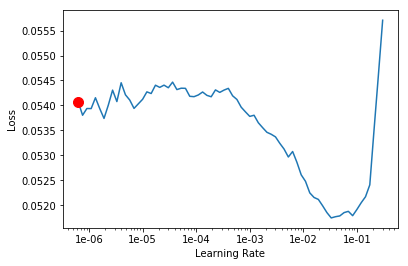

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
cb = SaveModelCallback(learn, monitor="lwlrap", every="improvement", name="final_pl_model")

In [ ]:
learn.fit_one_cycle(100, 1e-2, callbacks=cb)

epoch,train_loss,valid_loss,lwlrap,time
0,0.046228,0.033289,0.654721,01:07
1,0.044226,0.032848,0.656387,01:07
2,0.043896,0.032505,0.662634,01:08
3,0.043232,0.032704,0.656014,01:08
4,0.043151,0.032049,0.667161,01:08
5,0.042388,0.032529,0.655494,01:07
6,0.042373,0.032413,0.657803,01:08
7,0.042035,0.032174,0.660821,01:08
8,0.041703,0.032145,0.659218,01:08
9,0.041792,0.032173,0.660581,01:07


Better model found at epoch 0 with lwlrap value: 0.6547212362473108.
Better model found at epoch 1 with lwlrap value: 0.6563872299819553.
Better model found at epoch 2 with lwlrap value: 0.6626338995691264.
Better model found at epoch 4 with lwlrap value: 0.667161153884773.
